# Lab4 
  **Denoising with a CNN Autoencoder** (fashion mnist)

## Imports

In [50]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [51]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential

## Load the dataset

In [52]:
def map_image_with_noise(image, label):

  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  
  noise_factor = 0.25
  factor = noise_factor * tf.random.normal(shape=image.shape)
  image_noisy = image + factor
  image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)
 
  return image_noisy, image

In [53]:
BATCH_SIZE = 64

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test[:5000]")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE)

validation_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test[5000:]")
validation_dataset = validation_dataset.map(map_image_with_noise)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

## Build the Model

In [54]:
def auto_encoder():
  inputs = tf.keras.layers.Input(shape=(28, 28, 1,))

  conv_encoder = Sequential([
  layers.Input(shape=(28, 28, 1)),
  layers.Conv2D(16, (3, 3), activation=layers.LeakyReLU(), padding='same', strides=2),
  layers.Conv2D(32, (3, 3), activation=layers.LeakyReLU(), padding='same', strides=2)])

  conv_decoder = Sequential([
  layers.Conv2DTranspose(32, (3, 3), activation=layers.LeakyReLU(), padding='same', strides=2),
  layers.Conv2DTranspose(16, (3, 3), activation=layers.LeakyReLU(), padding='same', strides=2),
  layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  encoder_output = conv_encoder(inputs)
  decoder_output = conv_decoder(encoder_output)

  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

  return model, encoder_model

## Compile and Train the Model

In [55]:
model, encoder_model = auto_encoder()

train_steps = len(train_dataset)
valid_steps = len(test_dataset)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
history = model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=20)

Epoch 1/20
938/938 [==============================] - 15s 15ms/step - loss: 0.0325 - val_loss: 0.0095
Epoch 2/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 3/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 4/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 5/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 6/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 8/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 9/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 10/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0071 - val_loss: 0.00

## Display sample results


In [56]:
def display_one_row(disp_images, offset, k, shape=(28, 28)):
  for idx, noisy_image in enumerate(disp_images):
    plt.subplot(k, 12, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    noisy_image = np.reshape(noisy_image, shape)
    plt.imshow(noisy_image, cmap='gray')
    
def display_results(arrays, k, enc_shape=(8,4)):
  plt.figure(figsize=(25, 10))
  for i in range(len(arrays)):
    display_one_row(arrays[i], 12*i, k, shape=(28,28,))

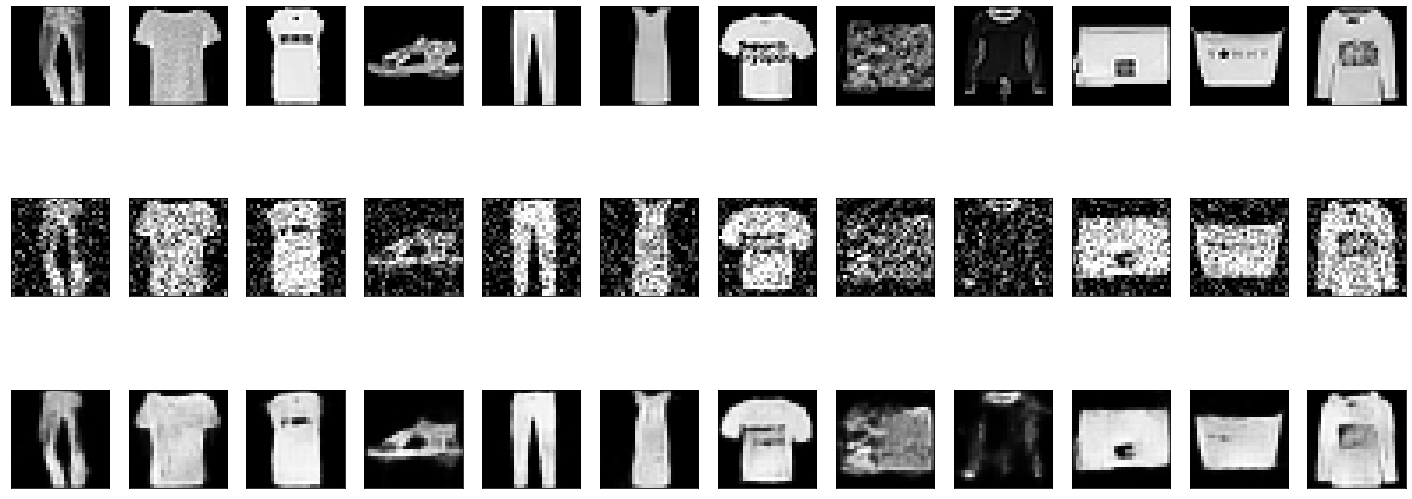

In [57]:
test = validation_dataset.take(1)

output_samples = []
clear_image = []
for input_image, image in tfds.as_numpy(test):
      output_samples, clear_image = input_image, image

conv_output_samples = np.array(output_samples[:12])
conv_output_samples = np.reshape(conv_output_samples, (12, 28, 28, 1))
clear_images = np.array(clear_image[:12])
clear_images = np.reshape(clear_images, (12, 28, 28, 1))

predicted = model.predict(conv_output_samples)
all_data = np.array([clear_images, conv_output_samples, predicted])
display_results(all_data, 3, enc_shape=(7,7))


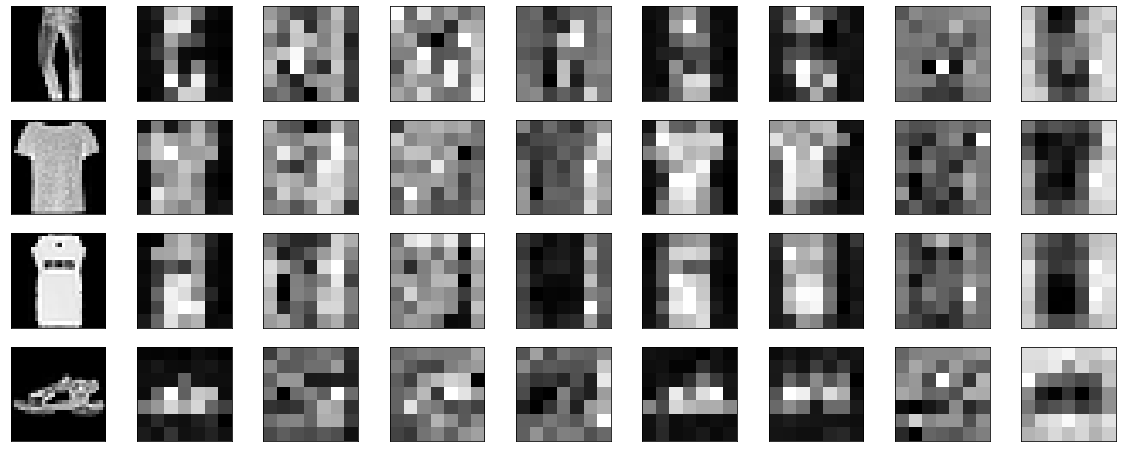

In [58]:
encoded_imgs = encoder_model.predict(conv_output_samples)
x_test = clear_image
plt.figure(figsize=(20, 8))
for j in range(4):
    ax_original = plt.subplot(4, 9, 1 + j * 9)
    plt.imshow(x_test[j, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    for i in range(8):
        ax_features = plt.subplot(4, 9, i + j * 9 + 2)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(encoded_imgs[j, :, :, i], cmap='gray')
plt.show()

In [59]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train[:600].astype('float32') / 255.
y_train = tf.keras.utils.to_categorical(y_train[:600], 10)
x_test = x_test.astype('float32') / 255.
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [60]:
lower_levels = encoder_model
for l in lower_levels.layers:
    l.trainable = False
    
class_model = Sequential([
    lower_levels,
    layers.Flatten(),
    layers.Dense(10, activation="softmax")])

class_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
history = class_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch=len(x_train), validation_steps=len(x_test), epochs=6)


Epoch 1/6
600/600 [==============================] - 22s 36ms/step - loss: 1.6556 - accuracy: 0.4699 - val_loss: 0.9530 - val_accuracy: 0.6542
Epoch 2/6
600/600 [==============================] - 21s 35ms/step - loss: 0.7313 - accuracy: 0.7454 - val_loss: 0.7954 - val_accuracy: 0.7287
Epoch 3/6
600/600 [==============================] - 21s 35ms/step - loss: 0.6318 - accuracy: 0.8075 - val_loss: 1.0126 - val_accuracy: 0.6995
Epoch 4/6
600/600 [==============================] - 21s 35ms/step - loss: 0.4500 - accuracy: 0.8555 - val_loss: 0.7265 - val_accuracy: 0.7735
Epoch 5/6
600/600 [==============================] - 21s 35ms/step - loss: 0.3799 - accuracy: 0.8673 - val_loss: 0.8466 - val_accuracy: 0.7417
Epoch 6/6
600/600 [==============================] - 21s 35ms/step - loss: 0.3669 - accuracy: 0.8668 - val_loss: 0.7996 - val_accuracy: 0.7445


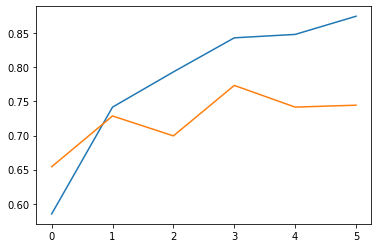

In [62]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')